In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
import os

In [ ]:
DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/HAR_Research_Project/transition/data/MHEALTHDATASET'
BASE_OUTPUT_DIR = '/content/drive/MyDrive/Colab Notebooks/HAR_Research_Project/transition/results'
TODAY_DATE = "20251206"

In [ ]:
# 분석할 Activity 목록
TARGET_ACTIVITIES = {
    6: 'Waist Bends',
    7: 'Arm Elevation',
    8: 'Crouching',
    12: 'Jump Front_Back'
}

In [ ]:
def load_mhealth_logs(data_dir):
    column_names = [
        'acx', 'acy', 'acz', 'ecg1', 'ecg2',
        'alx', 'aly', 'alz', 'glx', 'gly', 'glz', 'mlx', 'mly', 'mlz',
        'arx', 'ary', 'arz', 'grx', 'gry', 'grz', 'mrx', 'mry', 'mrz',
        'Activity'
    ]
    all_data = []
    print(f"Loading data from {data_dir}...")

    for subject_id in range(1, 11):
        file_name = f"mHealth_subject{subject_id}.log"
        file_path = os.path.join(data_dir, file_name)
        if not os.path.exists(file_path): continue

        try:
            df = pd.read_csv(file_path, header=None, sep='\s+')
            if df.shape[1] != 24: continue
            df.columns = column_names
            df['subject'] = subject_id
            all_data.append(df)
        except Exception:
            continue

    if not all_data: return None
    return pd.concat(all_data, ignore_index=True)

<>:17: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2084689864.py:17: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(file_path, header=None, sep='\s+')


In [ ]:
def calculate_metrics(data_cols):
    """
    3축 데이터를 받아 Magnitude를 구하고 QoS 지표를 반환
    """
    # Magnitude (Vector Sum)
    mag = np.sqrt(np.sum(data_cols**2, axis=1))

    # 1. SNR (Signal-to-Noise Ratio)
    # 일반적인 정의: Mean / Std (변동계수의 역수)
    # 신호가 클수록, 잡음(Std)이 작을수록 높게 나옴 -> "선명도"
    mean_val = np.mean(np.abs(mag))
    std_val = np.std(mag)
    snr = mean_val / (std_val + 1e-6) # 0 나누기 방지

    # 2. Kurtosis (첨도)
    # 분포가 얼마나 뾰족한가 (충격성 신호 감지)
    kurt_val = kurtosis(mag, fisher=True)

    # 3. Slope (기울기 변화율)
    # 신호가 얼마나 급격하게 변하는가 (Movement Intensity)
    slope = np.mean(np.abs(np.diff(mag)))

    return snr, kurt_val, slope

In [ ]:
def get_sensors_by_activity(act_id):
    """
    Activity별로 비교할 센서 부위 정의
    (Chest는 Gyro가 없으므로 예외 처리 필요)
    """
    if act_id == 6: # Waist Bends
        return ['acx', 'acy', 'acz'], ['arx', 'ary', 'arz'], "Chest Acc", "R-Arm Gyro"
        # Chest Gyro가 없어서 팔 Gyro랑 비교 (노이즈 확인용)
    elif act_id == 7: # Arm Elevation
        return ['arx', 'ary', 'arz'], ['grx', 'gry', 'grz'], "R-Arm Acc", "R-Arm Gyro"
    elif act_id == 8: # Crouching
        return ['alx', 'aly', 'alz'], ['glx', 'gly', 'glz'], "L-Ankle Acc", "L-Ankle Gyro"
    elif act_id == 12: # Jump
        return ['alx', 'aly', 'alz'], ['glx', 'gly', 'glz'], "L-Ankle Acc", "L-Ankle Gyro"
    return [], [], "", ""

In [ ]:
def analyze_and_plot_qos(df):
    results = []

    # 1. 지표 계산 Loop
    print(">>> Calculating QoS Metrics (SNR, Kurtosis, Slope)...")
    for act_id, act_name in TARGET_ACTIVITIES.items():
        act_df = df[df['Activity'] == act_id]

        acc_cols, gyro_cols, acc_label, gyro_label = get_sensors_by_activity(act_id)

        for sub in act_df['subject'].unique():
            sub_data = act_df[act_df['subject'] == sub]

            # Acc Metrics
            acc_data = sub_data[acc_cols].values
            acc_snr, acc_kurt, acc_slope = calculate_metrics(acc_data)

            # Gyro Metrics
            gyro_data = sub_data[gyro_cols].values
            gyro_snr, gyro_kurt, gyro_slope = calculate_metrics(gyro_data)

            results.append({
                'Activity': act_name,
                'Subject': sub,
                'Acc_SNR': acc_snr, 'Gyro_SNR': gyro_snr,
                'Acc_Kurtosis': acc_kurt, 'Gyro_Kurtosis': gyro_kurt,
                'Acc_Slope': acc_slope, 'Gyro_Slope': gyro_slope,
                'Acc_Label': acc_label, 'Gyro_Label': gyro_label
            })

    qos_df = pd.DataFrame(results)

    # CSV 저장
    os.makedirs(BASE_OUTPUT_DIR, exist_ok=True)
    csv_path = os.path.join(BASE_OUTPUT_DIR, f'QoS_Metrics_Report_{TODAY_DATE}.csv')
    qos_df.to_csv(csv_path, index=False)
    print(f"Numeric Data Saved: {csv_path}")

    # 2. Heatmap 시각화 Loop (지표별)
    metrics = ['SNR', 'Kurtosis', 'Slope']

    for metric in metrics:
        # 캔버스: Activity 개수만큼 행 생성
        fig, axes = plt.subplots(len(TARGET_ACTIVITIES), 2, figsize=(16, 5 * len(TARGET_ACTIVITIES)))
        fig.suptitle(f"Sensor Comparison - {metric} (Left: Acc vs Right: Gyro)", fontsize=16, fontweight='bold', y=1.01)

        for idx, (act_id, act_name) in enumerate(TARGET_ACTIVITIES.items()):
            subset = qos_df[qos_df['Activity'] == act_name]

            # Acc Heatmap
            pivot_acc = subset.pivot(index='Subject', columns='Activity', values=f'Acc_{metric}')
            sns.heatmap(pivot_acc, annot=True, fmt=".2f", cmap="Greens", ax=axes[idx, 0])
            axes[idx, 0].set_title(f"{act_name}: {subset.iloc[0]['Acc_Label']} ({metric})")

            # Gyro Heatmap
            pivot_gyro = subset.pivot(index='Subject', columns='Activity', values=f'Gyro_{metric}')
            sns.heatmap(pivot_gyro, annot=True, fmt=".2f", cmap="Purples", ax=axes[idx, 1])
            axes[idx, 1].set_title(f"{act_name}: {subset.iloc[0]['Gyro_Label']} ({metric})")

        plt.tight_layout()

        # 그래프 저장
        save_name = f"QoS_Heatmap_{metric}_{TODAY_DATE}.png"
        save_path = os.path.join(BASE_OUTPUT_DIR, save_name)
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Heatmap Saved: {save_name}")
        plt.show()

Loading data from /content/drive/MyDrive/Colab Notebooks/HAR_Research_Project/transition/data/MHEALTHDATASET...
>>> Calculating QoS Metrics (SNR, Kurtosis, Slope)...
Numeric Data Saved: /content/drive/MyDrive/Colab Notebooks/HAR_Research_Project/transition/results/QoS_Metrics_Report_20251206.csv
Heatmap Saved: QoS_Heatmap_SNR_20251206.png


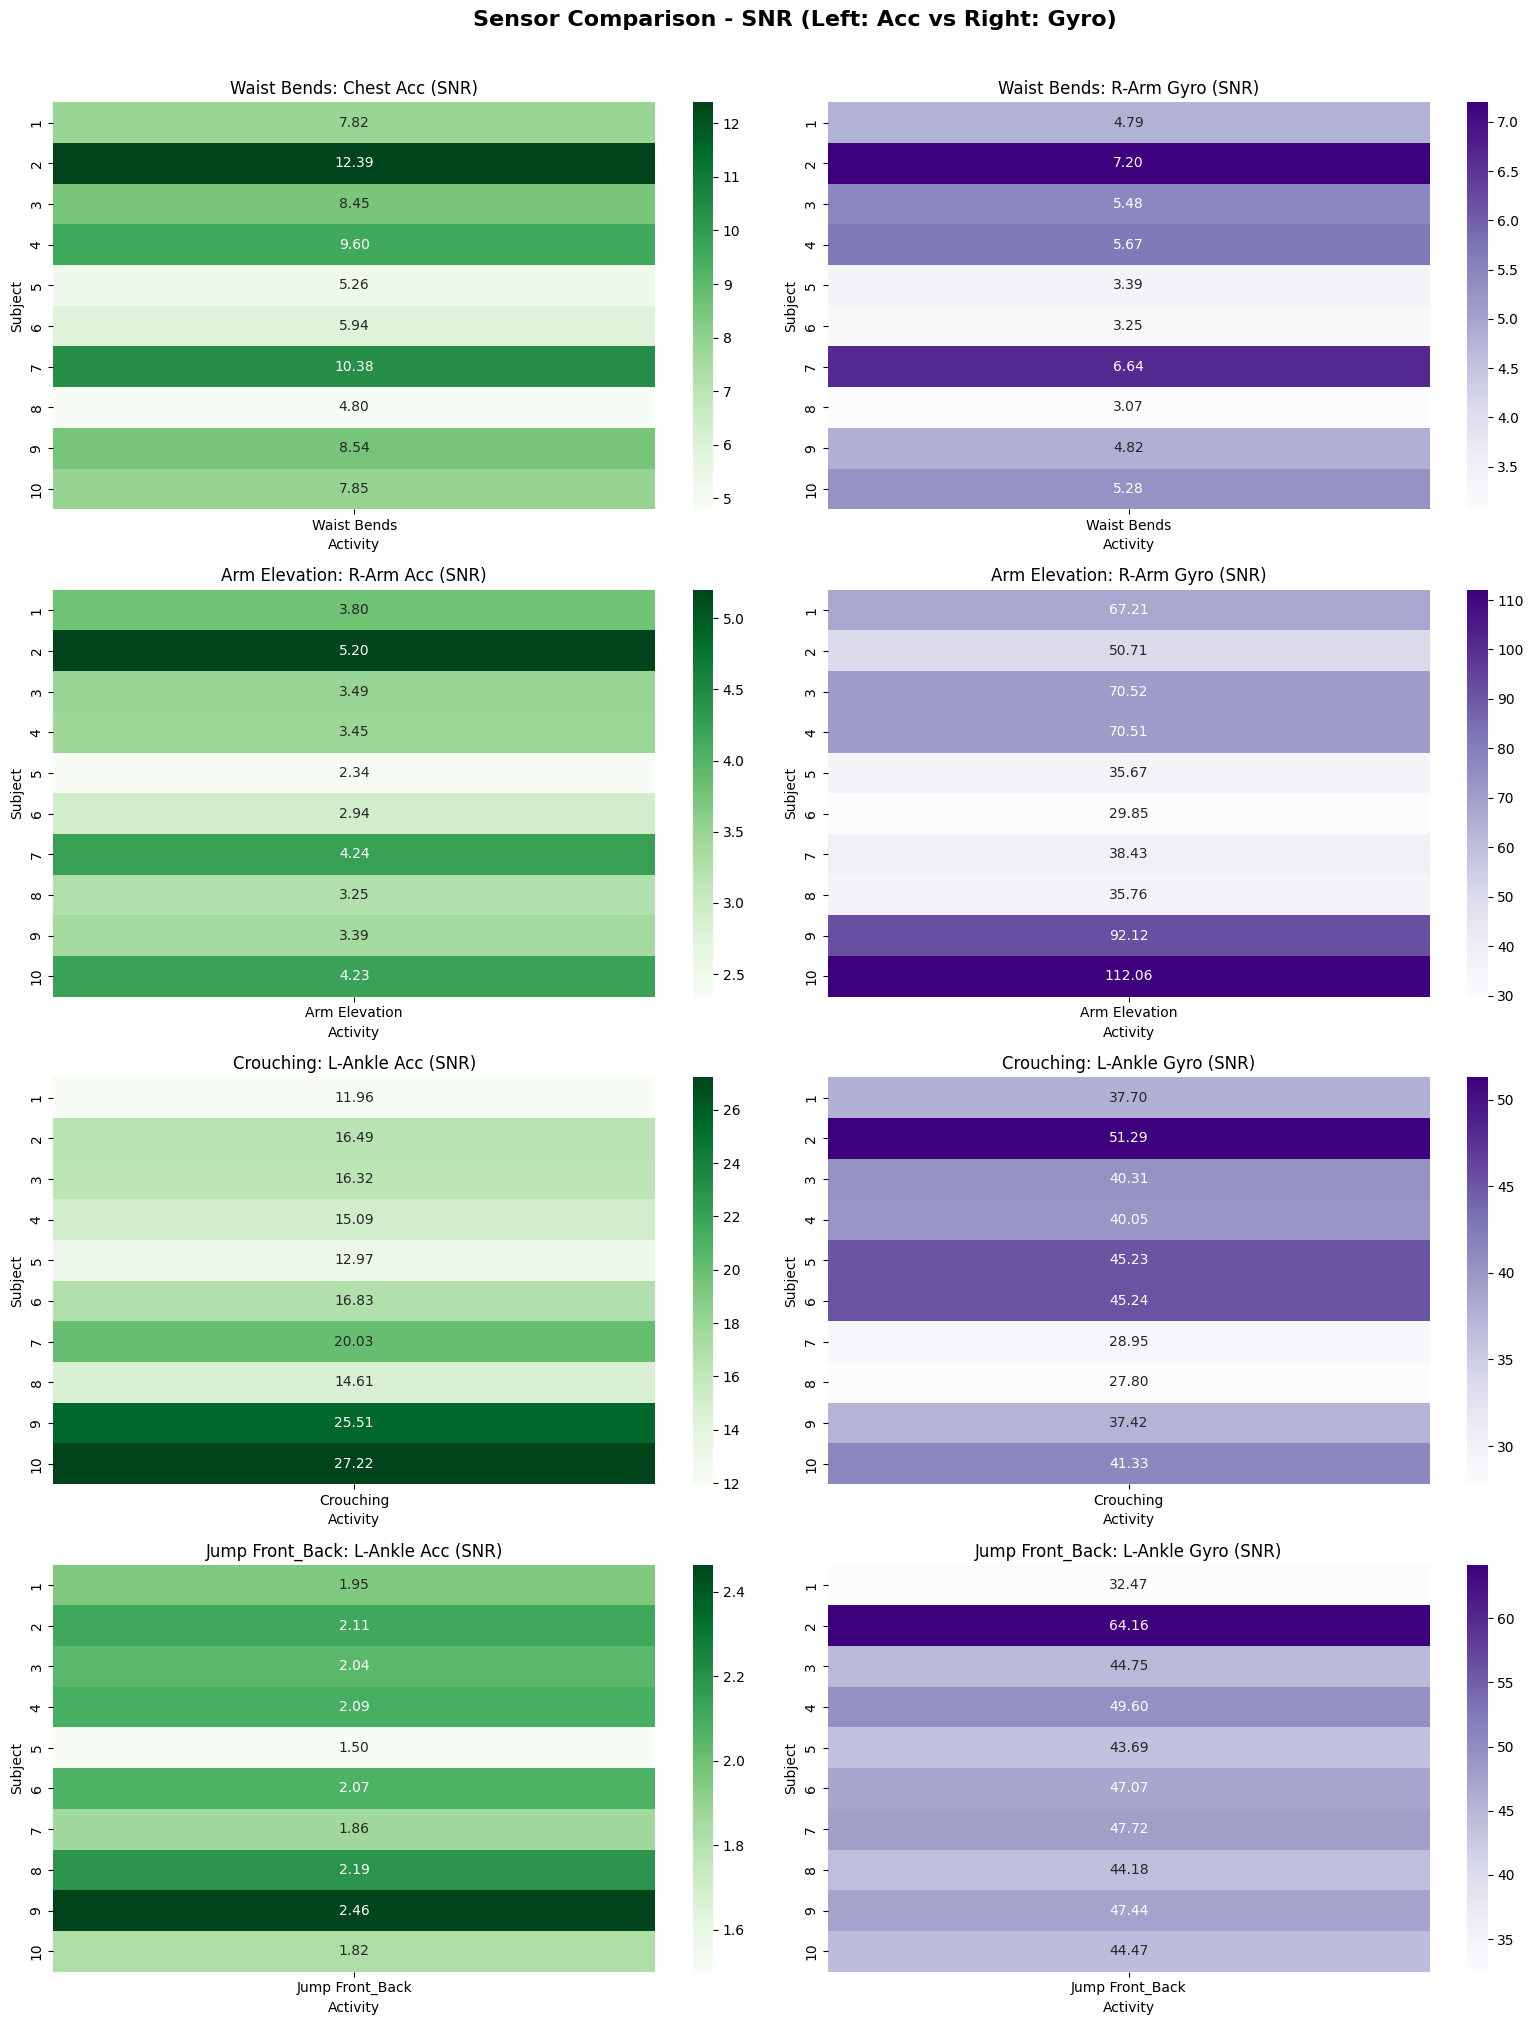

Heatmap Saved: QoS_Heatmap_Kurtosis_20251206.png


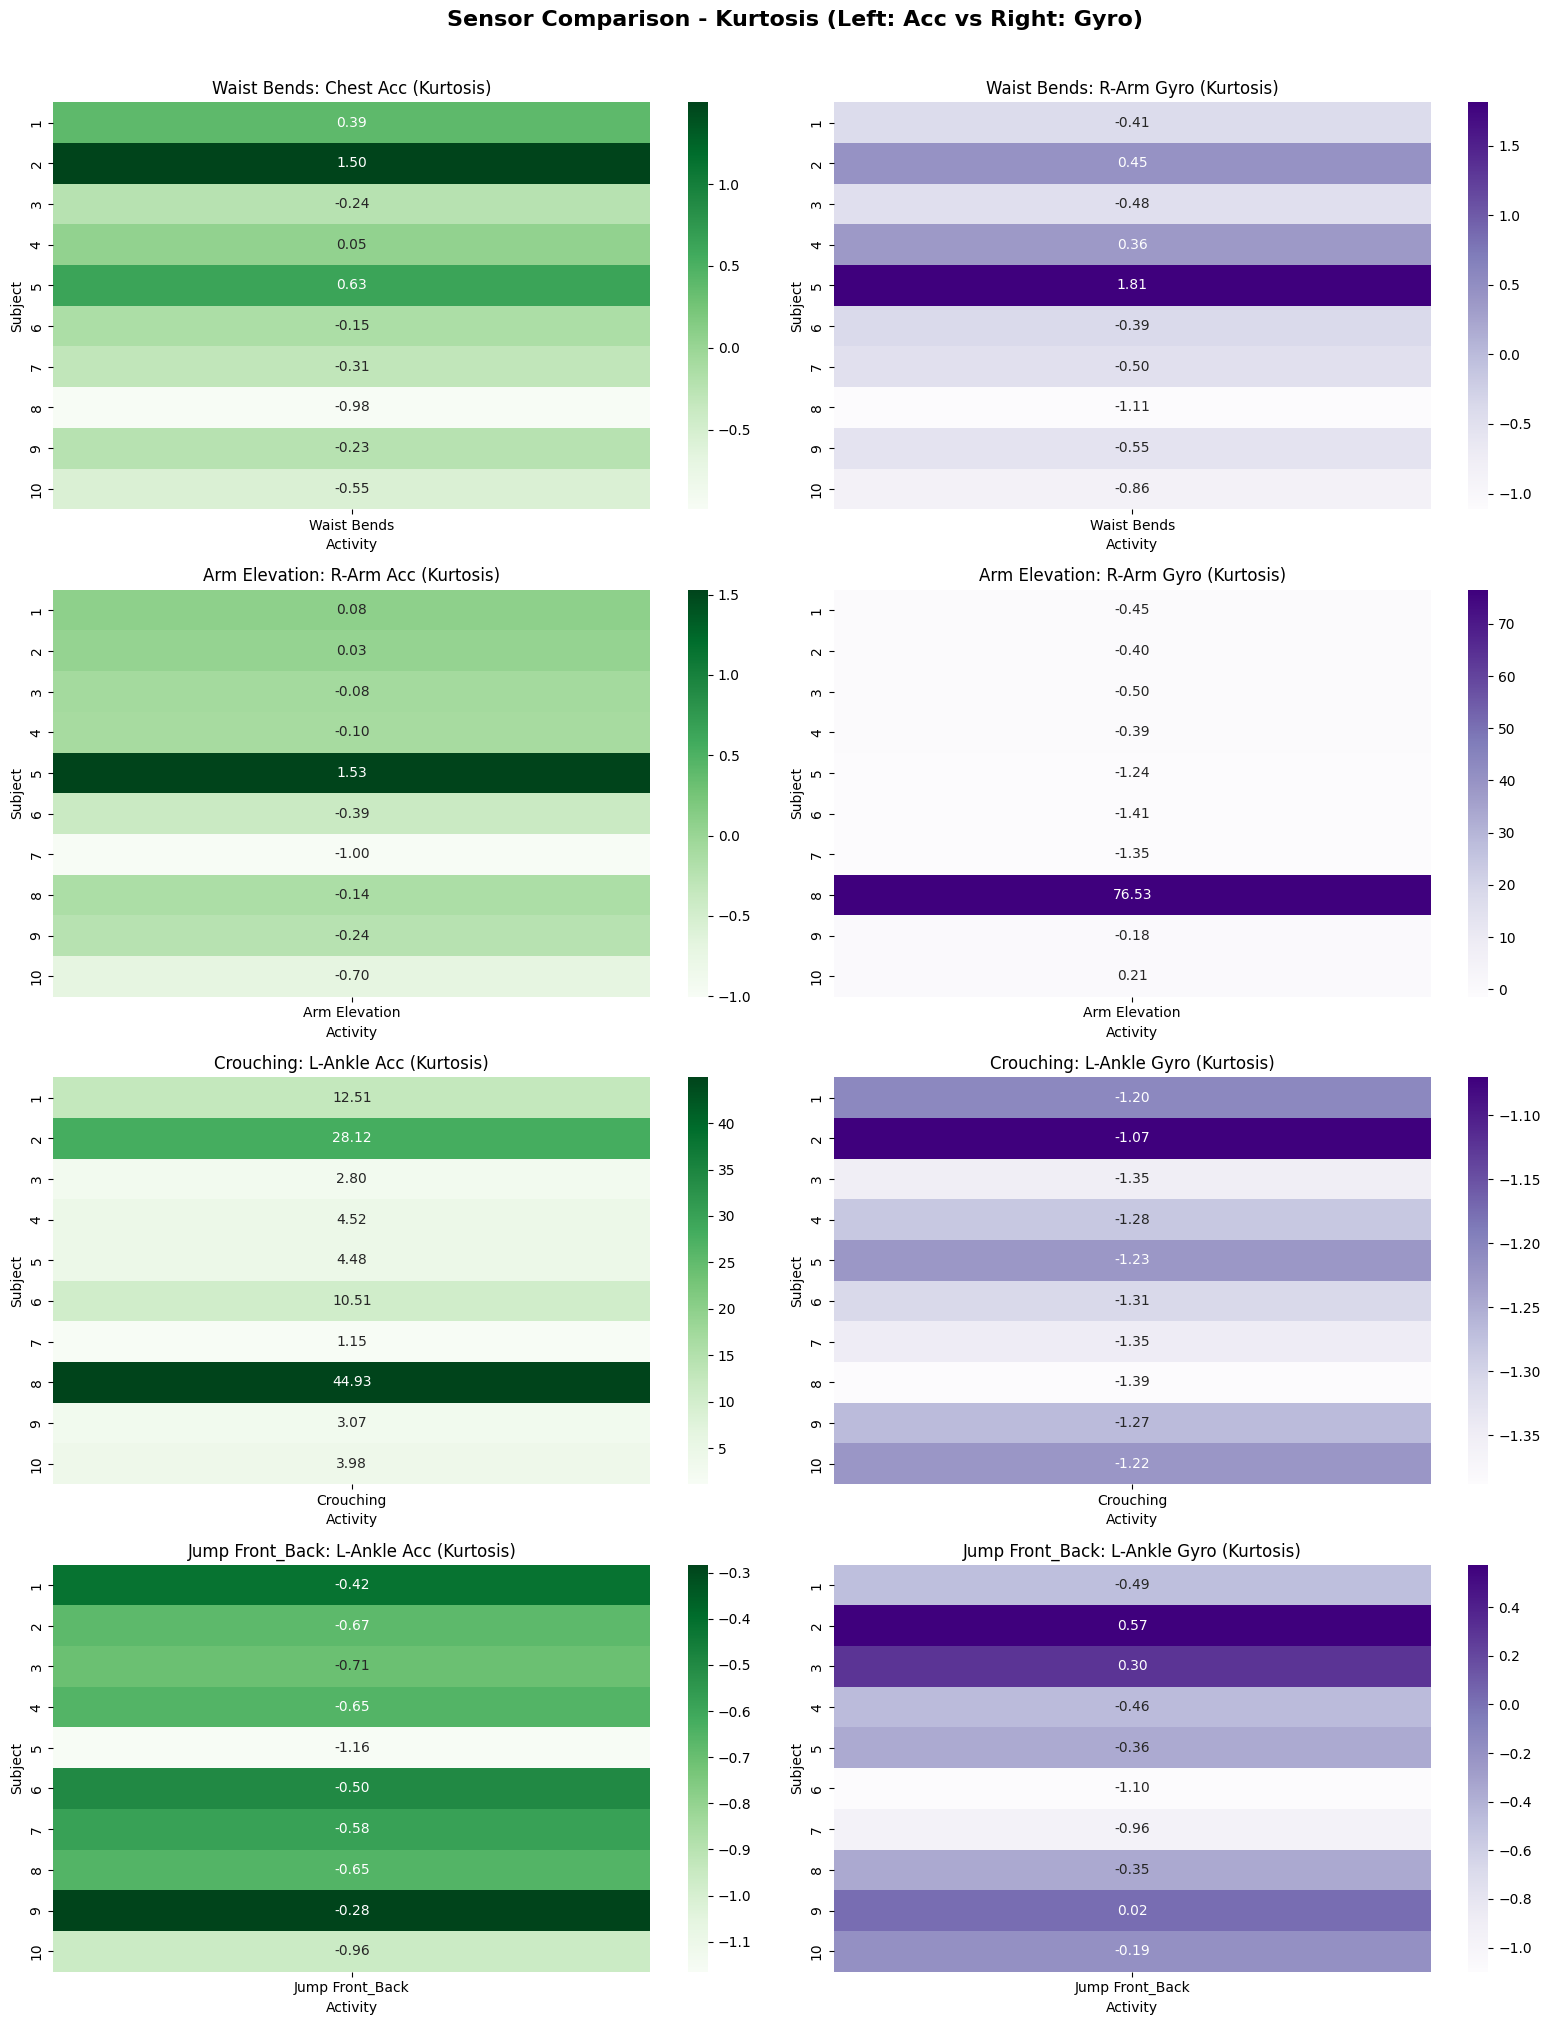

Heatmap Saved: QoS_Heatmap_Slope_20251206.png


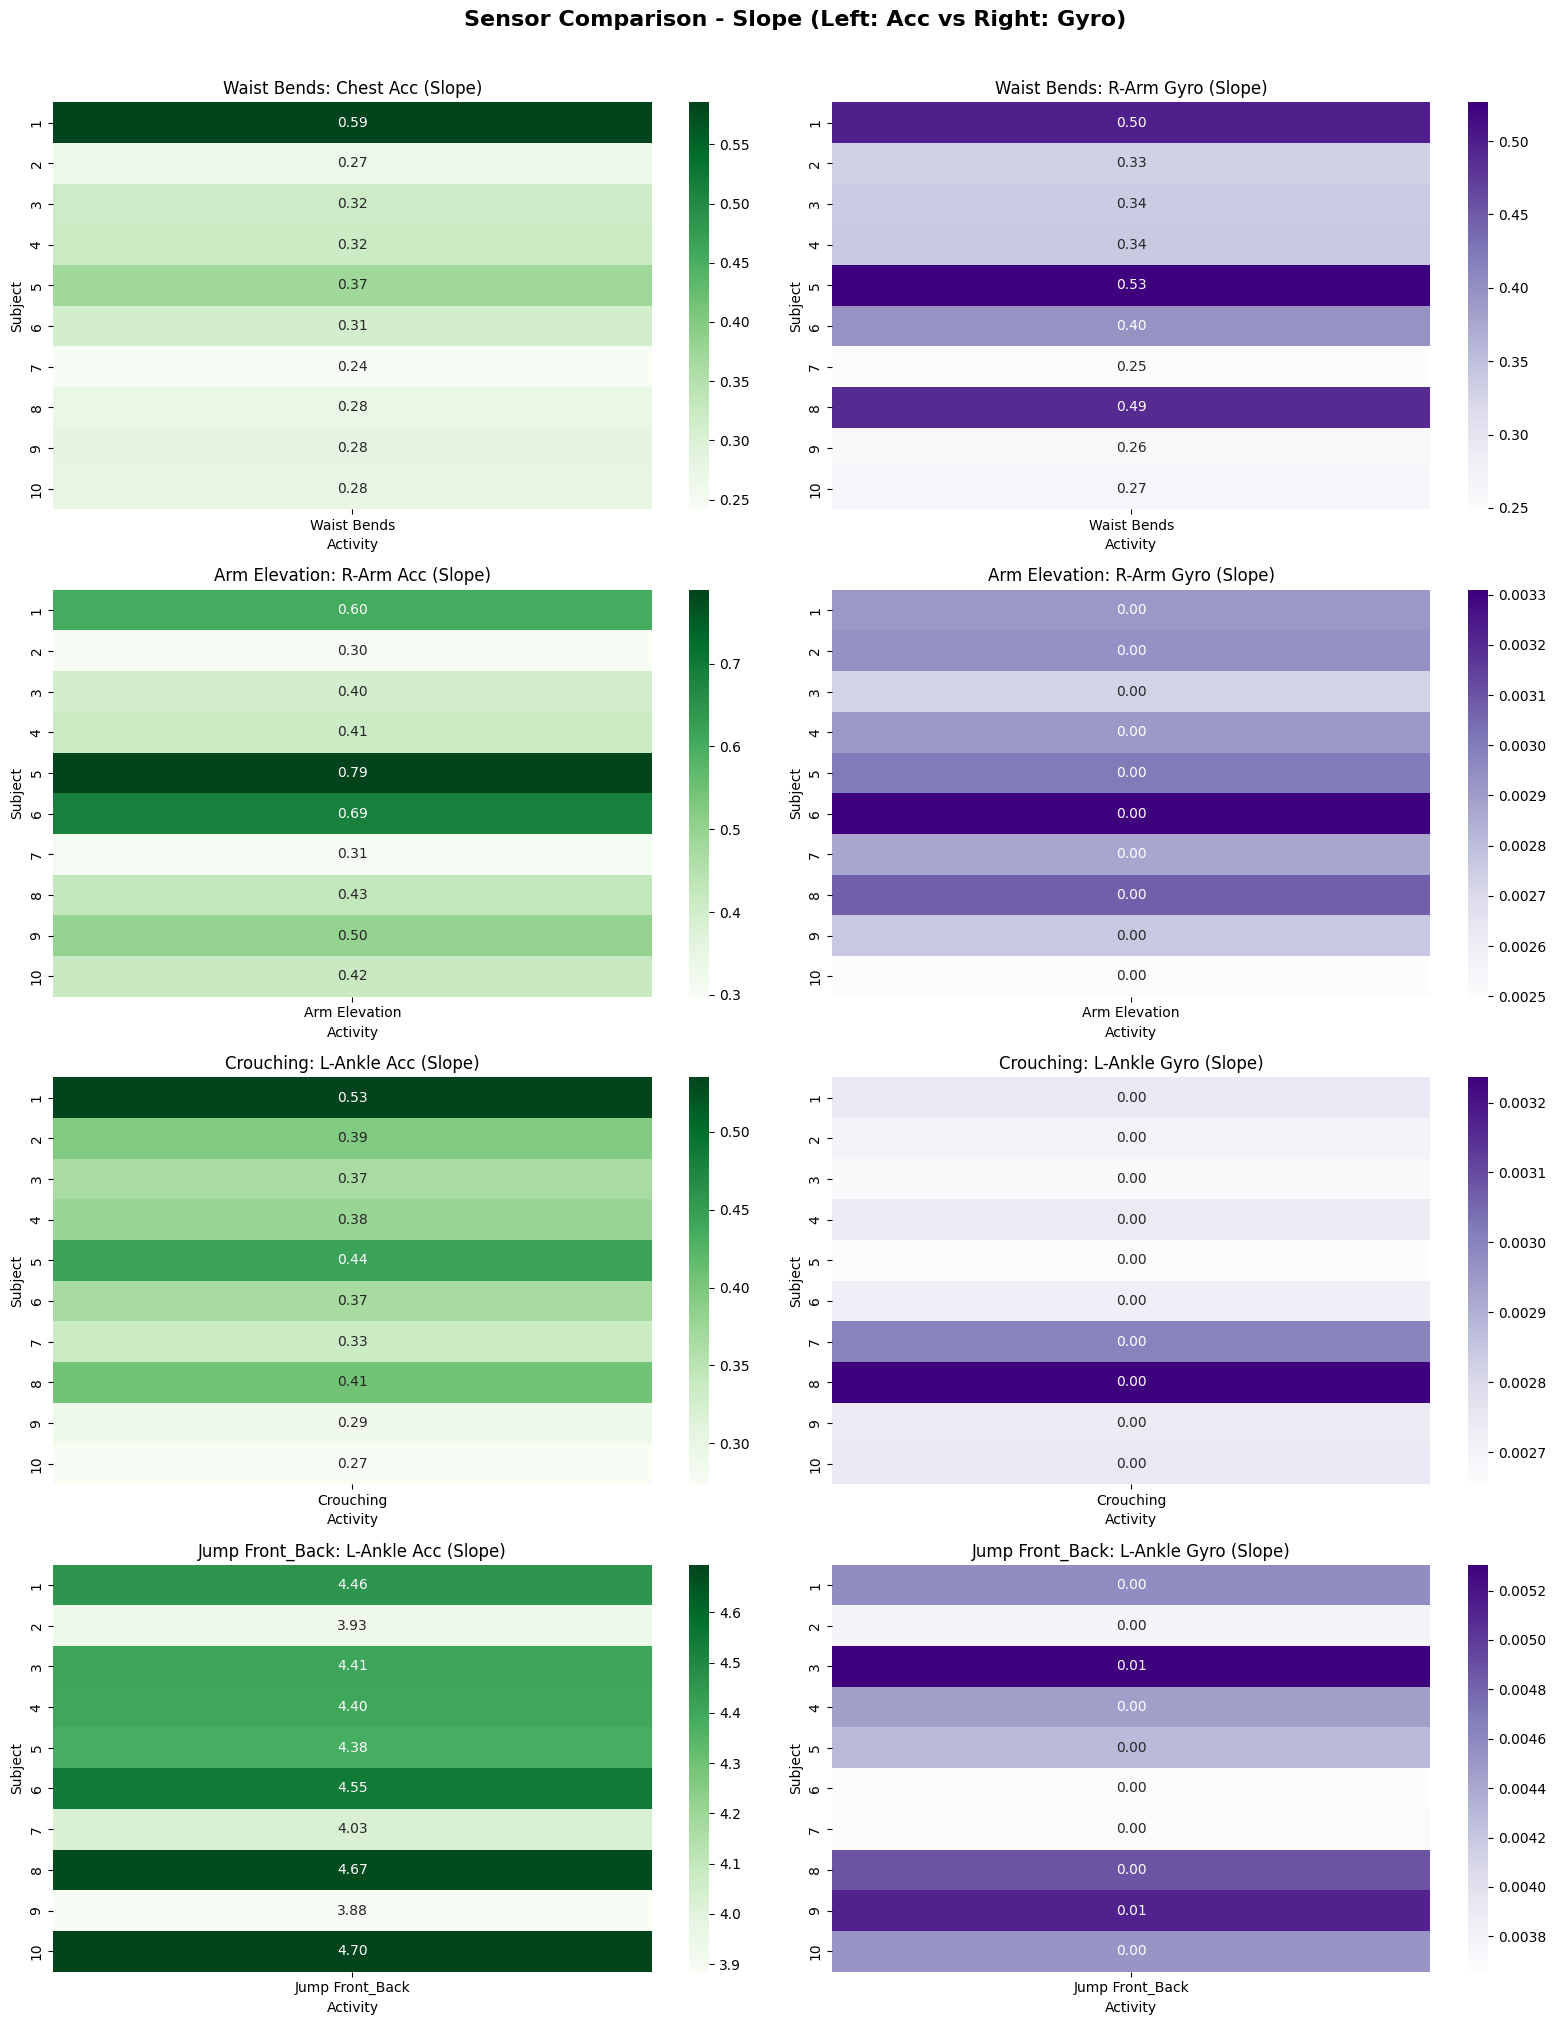

In [ ]:
if __name__ == "__main__":
    df = load_mhealth_logs(DATA_DIR)
    if df is not None:
        analyze_and_plot_qos(df)